In [1]:
import pickle
import os
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np

## 1.1 load the data

In [2]:
root = "/home/chaoqiy2/data/MNIST/Spatio-temporal/"
covid_tensor = torch.Tensor(
    pickle.load(open(os.path.join(root, "covid_tensor.pkl"), "rb"))
)

claim_tensor = torch.Tensor(
    pickle.load(open(os.path.join(root, "claim_tensor.pkl"), "rb"))
)
# claim_tensor = claim_tensor[covid_tensor.sum(1) > 0]

county_tensor = torch.Tensor(
    pickle.load(open(os.path.join(root, "county_tensor.pkl"), "rb"))
)
# county_tensor = county_tensor[covid_tensor.sum(1) > 0]

distance_mat = torch.Tensor(
    pickle.load(open(os.path.join(root, "distance_mat.pkl"), "rb"))
)
# distance_mat = distance_mat[covid_tensor.sum(1) > 0, covid_tensor.sum(1) > 0]

hos_tensor = torch.Tensor(pickle.load(open(os.path.join(root, "hos_tensor.pkl"), "rb")))
# hos_tensor = hos_tensor[covid_tensor.sum(1) > 0]

mob_mat = torch.Tensor(pickle.load(open(os.path.join(root, "mob_mat.pkl"), "rb")))
# mob_mat = mob_mat[covid_tensor.sum(1) > 0]

vac_tensor = torch.Tensor(pickle.load(open(os.path.join(root, "vac_tensor.pkl"), "rb")))
# vac_tensor = vac_tensor[covid_tensor.sum(1) > 0]

# covid_tensor = covid_tensor[covid_tensor.sum(1) > 0]

feat_name = pickle.load(open(os.path.join(root, "feat_name.pkl"), "rb"))

device = "cuda:0"
demographs = county_tensor
daily = torch.cat(
    [claim_tensor, covid_tensor.unsqueeze(-1), hos_tensor, vac_tensor], dim=-1
).to(device)
graph1 = distance_mat.to(device)
graph2 = mob_mat.to(device)

print(demographs.shape, daily.shape, graph1.shape, graph2.shape)

torch.Size([2334, 14]) torch.Size([2334, 639, 59]) torch.Size([2334, 2334]) torch.Size([2334, 2334])


In [14]:
feat_name

{'hospitalization': ['inbeds', 'inbeds_covid', 'icu', 'icu_covid'],
 'vaccination': ['1st',
  '2nd',
  'bst',
  'Pfizer_1',
  'Pfizer_2',
  'Pfizer_b',
  'Moderna_1',
  'Moderna_2',
  'Moderna_b',
  'Johnson_1',
  'Johnson_b',
  'PfizerTS_1',
  'PfizerTS_2',
  'PfizerTS_b',
  'PfizerTS10_1',
  'PfizerTS10_2'],
 'claim': ['hospitalization',
  'n_visits',
  'age_cnt',
  'Cerebrovascular Disease',
  'Chronic Pulmonary Disease',
  'Congestive Heart Failure',
  'Dementia',
  'Diabetes without chronic complication',
  'HIV',
  'Hemiplegia or Paraplegia',
  'Hypertension',
  'Immunodeficiency',
  'Liver Disease',
  'Malignancy',
  'Metastatic Solid Tumor',
  'Myocardial Infarction',
  'Obesity',
  'Peptic Ulcer Disease',
  'Peripheral Vascular Disease',
  'Renal'],
 'county': ['pop',
  '0_17',
  '18_64',
  '65p',
  'Black',
  'White',
  'Asian',
  'Hispanic',
  'Not_Hispanic',
  'Physicians',
  'Hospitals',
  'ICU Beds',
  'Income',
  'Unemployment_rate'],
 'date': ['2020-08-01',
  '2020-08-0

## 1.2 Algorithms

In [3]:
def optimize(A, B, D, reg=1e-8):
    u = torch.linalg.solve(A + reg * D, B)
    return u

def CPD_2d(T, A1, A2, D, iteration=20):
    for i in range(iteration):
        A1 = optimize(A2.T@A2, torch.einsum('ij,jr->ri',T,A2), D).T
        A2 = optimize(A1.T@A1, torch.einsum('ij,ir->rj',T,A1), D).T

        rec = torch.einsum('ir,jr->ij',A1,A2)
        loss = (torch.norm(rec - T) / torch.norm(T))**2
        print ('{}/{}'.format(i, iteration), 'fitness loss:', loss.item())
    result = [item.cpu().numpy() for item in [A1, A2]]
    return result

def CPD_3d(T, A1, A2, A3, D, iteration=20):
    for i in range(iteration):
        A1 = optimize((A3.T@A3)*(A2.T@A2), torch.einsum('ijk,jr,kr->ri',T,A2,A3), D).T
        A2 = optimize((A1.T@A1)*(A3.T@A3), torch.einsum('ijk,ir,kr->rj',T,A1,A3), D).T
        A3 = optimize((A1.T@A1)*(A2.T@A2), torch.einsum('ijk,ir,jr->rk',T,A1,A2), D).T

        rec = torch.einsum('ir,jr,kr->ijk',A1,A2,A3)
        loss = (torch.norm(rec - T) / torch.norm(T))**2
        print ('{}/{}'.format(i, iteration), 'fitness loss:', loss.item())
        result = [item.cpu().numpy() for item in [A1, A2, A3]]
    return result


def NTF_2d(T, A1, A2, D, iteration=50):
    for i in range(iteration):
        A1 = optimize(A2.T@A2, torch.einsum('ij,jr->ri',T,A2), D).T
        A1 = torch.clip(A1, min=1e-8)
        A2 = optimize(A1.T@A1, torch.einsum('ij,ir->rj',T,A1), D).T
        A2 = torch.clip(A2, min=1e-8)

        rec = torch.einsum('ir,jr->ij',A1,A2)
        loss = (torch.norm(rec - T) / torch.norm(T))**2
        print ('{}/{}'.format(i, iteration), 'fitness loss:', loss.item())
        result = [item.cpu().numpy() for item in [A1, A2]]
    return result

def NTF_3d(T, A1, A2, A3, D, iteration=50):
    for i in range(iteration):
        A1 = optimize((A3.T@A3)*(A2.T@A2), torch.einsum('ijk,jr,kr->ri',T,A2,A3), D).T
        A1 = torch.clip(A1, min=1e-8)
        A2 = optimize((A1.T@A1)*(A3.T@A3), torch.einsum('ijk,ir,kr->rj',T,A1,A3), D).T
        A2 = torch.clip(A2, min=1e-8)
        A3 = optimize((A1.T@A1)*(A2.T@A2), torch.einsum('ijk,ir,jr->rk',T,A1,A2), D).T
        A3 = torch.clip(A3, min=1e-8)

        rec = torch.einsum('ir,jr,kr->ijk',A1,A2,A3)
        loss = (torch.norm(rec - T) / torch.norm(T))**2
        print ('{}/{}'.format(i, iteration), 'fitness loss:', loss.item())
        result = [item.cpu().numpy() for item in [A1, A2, A3]]
    return result

def initialize(T, R, device):
    return *[torch.randn(I, R).to(device) for I in T.shape], torch.eye(R).to(device)

def get_laplacian(A, normalized=True):
    # -------------------------------
    # calculate the laplacian
    A = torch.Tensor(A)
    D = A.sum(axis=1)
    if normalized:
        D_rev = torch.diag(D ** (-0.5))
        L = torch.eye(len(D)) - D_rev @ A @ D_rev
    else:
        L = torch.diag(D) - A
    L = L.to(device)
    # ---------------------------------
    return L

## 2.1 ensure ```demographs``` can fit tensor decomposition

In [4]:
# use MAX-MIN normalization
features = {
    0: 'pop',
    1: '0_17',
    2: '18_64',
    3: '65p',
    4: 'Black',
    5: 'White',
    6: 'Asian',
    7: 'Hispanic',
    8: 'Not_Hispanic',
    9: 'Physicians',
    10: 'Hospitals',
    11: 'ICU Beds',
    12: 'Income',
    13: 'Unemployment_rate'}

demographs_ = demographs[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13]].to(device)
demographs_ = (demographs_ - demographs_.min(0).values.reshape(1,-1)) / \
        (demographs_.max(0).values.reshape(1,-1) - demographs_.min(0).values.reshape(1,-1))

device = "cuda:0"
A1, A2, D = initialize(demographs_, R=4, device=device)
A1, A2 = NTF_2d(demographs_, A1, A2, D, iteration=20)

0/20 fitness loss: 0.2143709808588028
1/20 fitness loss: 0.17054203152656555
2/20 fitness loss: 0.018022850155830383
3/20 fitness loss: 0.007540449965745211
4/20 fitness loss: 0.005756039638072252
5/20 fitness loss: 0.005289556924253702
6/20 fitness loss: 0.005140317138284445
7/20 fitness loss: 0.005082943011075258
8/20 fitness loss: 0.0050541977398097515
9/20 fitness loss: 0.0050364891067147255
10/20 fitness loss: 0.005024017300456762
11/20 fitness loss: 0.005014432594180107
12/20 fitness loss: 0.00500688748434186
13/20 fitness loss: 0.005000907927751541
14/20 fitness loss: 0.004996135365217924
15/20 fitness loss: 0.004992314614355564
16/20 fitness loss: 0.004989258944988251
17/20 fitness loss: 0.004986831918358803
18/20 fitness loss: 0.004984935745596886
19/20 fitness loss: 0.004983426071703434


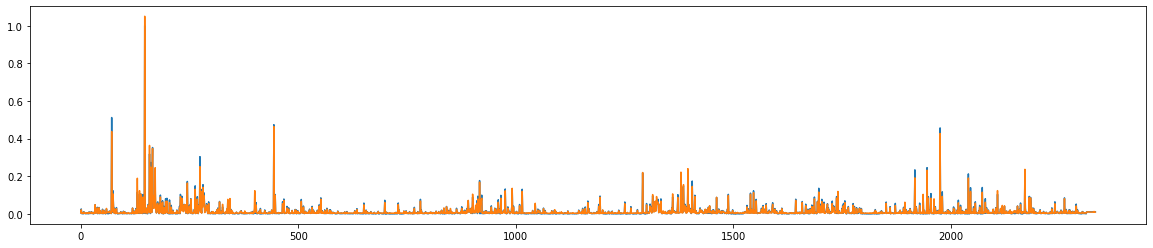

In [5]:
idx = 5
log_scale = False
####################

rec = A1 @ A2.T
plt.figure(figsize=(20, 4))

if log_scale:
    plt.plot(np.log(demographs_[:, idx].cpu().numpy() + 1))
    plt.plot(np.log(rec[:, idx] + 1))
else:
    plt.plot(demographs_[:, idx].cpu().numpy())
    plt.plot(rec[:, idx])

# for idx in range (10):
#     print (np.corrcoef([demographs_[:, idx].cpu().numpy(), rec[:, idx]]))

## 2.2 ensure ```daily``` can fit tensor decomposition

tensor(0.9337, device='cuda:0')


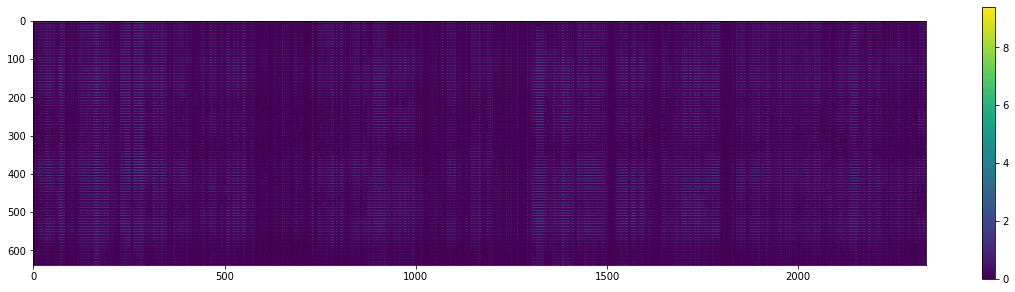

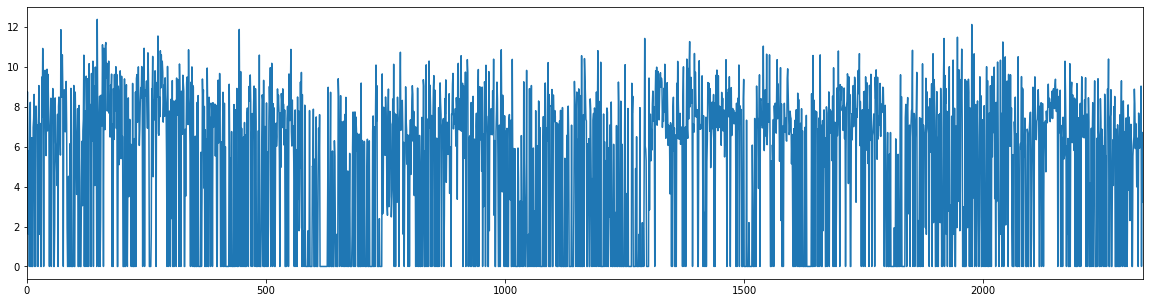

In [6]:
idx = 24
use_log = True
#############

plt.figure(figsize=(20, 5))
if not use_log:
    plt.imshow(daily[:, :, idx].cpu().numpy().T)
else:
    plt.imshow(np.log(daily[:, :, idx].cpu().numpy().T + 1))
plt.colorbar()

plt.figure(figsize=(20, 5))
if not use_log:
    plt.plot(daily[:, :, idx].sum(1).cpu().numpy().T)
else:
    plt.plot(np.log(daily[:, :, idx].sum(1).cpu().numpy().T + 1))
plt.xlim([0, 2334])
print ((daily[:, :, idx] == 0).sum() / 2334 / 639)

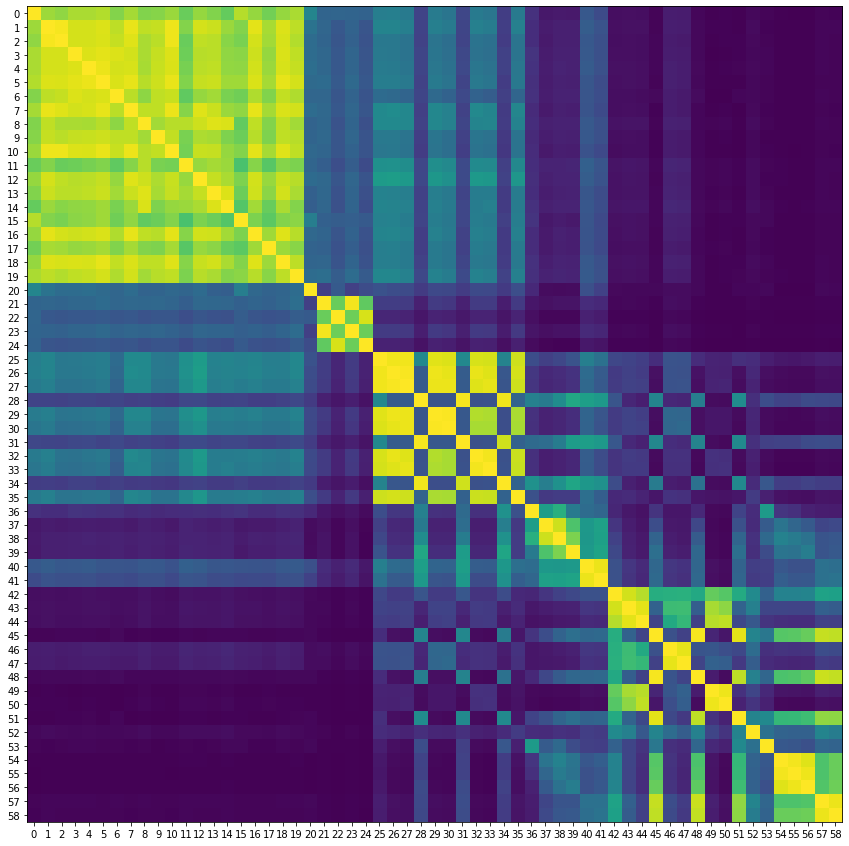

In [7]:
# use MAX-MIN normalization
claims = {
    0: 'hospitalization',
    1: 'n_visits',
    2: 'age_cnt',
    3: 'Cerebrovascular Disease',
    4: 'Chronic Pulmonary Disease',
    5: 'Congestive Heart Failure',
    6: 'Dementia',
    7: 'Diabetes without chronic complication',
    8: 'HIV',
    9: 'Hemiplegia or Paraplegia',
    10: 'Hypertension',
    11: 'Immunodeficiency',
    12: 'Liver Disease',
    13: 'Malignancy',
    14: 'Metastatic Solid Tumor',
    15: 'Myocardial Infarction',
    16: 'Obesity',
    17: 'Peptic Ulcer Disease',
    18: 'Peripheral Vascular Disease',
    19: 'Renal',
    20: 'covid_cases'}

hospitalization = {21: 'inbeds', 22: 'inbeds_covid', 23: 'icu', 24: 'icu_covid'}

vaccination = {
    25: 'total',
    26: '1st',
    27: '2nd',
    28: 'bst',
    29: 'Pfizer_1',
    30: 'Pfizer_2',
    31: 'Pfizer_b',
    32: 'Moderna_1',
    33: 'Moderna_2',
    34: 'Moderna_b',
    35: 'Johnson_1',
    36: 'Johnson_b',
    37: 'PfizerTS_1',
    38: 'PfizerTS_2',
    39: 'PfizerTS_b',
    40: 'PfizerTS10_1',
    41: 'PfizerTS10_2',
    42: 'total_rate',
    43: '1st_rate',
    44: '2nd_rate',
    45: 'bst_rate',
    46: 'Pfizer_1_rate',
    47: 'Pfizer_2_rate',
    48: 'Pfizer_b_rate',
    49: 'Moderna_1_rate',
    50: 'Moderna_2_rate',
    51: 'Moderna_b_rate',
    52: 'Johnson_1_rate',
    53: 'Johnson_b_rate',
    54: 'PfizerTS_1_rate',
    55: 'PfizerTS_2_rate',
    56: 'PfizerTS_b_rate',
    57: 'PfizerTS10_1_rate',
    58: 'PfizerTS10_2_rate'}


daily_ = daily.clone()
daily_MIN = daily_.min(0).values.min(0).values.unsqueeze(0).unsqueeze(0)
daily_MAX = daily_.max(0).values.max(0).values.unsqueeze(0).unsqueeze(0)
daily_ = (daily_ - daily_MIN) / (daily_MAX - daily_MIN + 1e-8)

plt.figure(figsize=(15, 15))
plt.imshow(np.corrcoef(daily_.permute(2,0,1).reshape(59, -1).cpu().numpy()))
plt.xticks(np.arange(59), np.arange(59))
plt.yticks(np.arange(59), np.arange(59))
print ()

In [8]:
idx = 0
device = "cuda:0"
A1, A2, A3 = NTF_3d(daily_[:, :, :20], *initialize(daily_[:, :, :20], R=1, device=device), iteration=20)

0/20 fitness loss: 1.0
1/20 fitness loss: 0.10611892491579056
2/20 fitness loss: 0.1053265929222107
3/20 fitness loss: 0.10532578080892563
4/20 fitness loss: 0.10532578080892563
5/20 fitness loss: 0.10532578080892563
6/20 fitness loss: 0.10532578080892563
7/20 fitness loss: 0.10532578080892563
8/20 fitness loss: 0.10532578080892563
9/20 fitness loss: 0.10532578080892563
10/20 fitness loss: 0.10532578080892563
11/20 fitness loss: 0.10532578080892563
12/20 fitness loss: 0.10532578080892563
13/20 fitness loss: 0.10532578080892563
14/20 fitness loss: 0.10532578080892563
15/20 fitness loss: 0.10532578080892563
16/20 fitness loss: 0.10532578080892563
17/20 fitness loss: 0.10532578080892563
18/20 fitness loss: 0.10532578080892563
19/20 fitness loss: 0.10532578080892563


### 3.1 re-organize the tensor and check correlation

0/20 fitness loss: 0.47988635301589966
1/20 fitness loss: 0.11060428619384766
2/20 fitness loss: 0.1075470820069313
3/20 fitness loss: 0.10753051936626434
4/20 fitness loss: 0.10753042250871658
5/20 fitness loss: 0.10753042250871658
6/20 fitness loss: 0.10753042250871658
7/20 fitness loss: 0.10753042250871658
8/20 fitness loss: 0.10753042250871658
9/20 fitness loss: 0.10753042250871658
10/20 fitness loss: 0.10753042250871658
11/20 fitness loss: 0.10753042250871658
12/20 fitness loss: 0.10753042250871658
13/20 fitness loss: 0.10753042250871658
14/20 fitness loss: 0.10753042250871658
15/20 fitness loss: 0.10753042250871658
16/20 fitness loss: 0.10753042250871658
17/20 fitness loss: 0.10753042250871658
18/20 fitness loss: 0.10753042250871658
19/20 fitness loss: 0.10753042250871658
0/50 fitness loss: 0.706137478351593
1/50 fitness loss: 0.15401031076908112
2/50 fitness loss: 0.12385444343090057
3/50 fitness loss: 0.10656630992889404
4/50 fitness loss: 0.10250671952962875
5/50 fitness loss:

40/50 fitness loss: 0.015986016020178795
41/50 fitness loss: 0.015985876321792603
42/50 fitness loss: 0.015985744073987007
43/50 fitness loss: 0.015985604375600815
44/50 fitness loss: 0.01598546840250492
45/50 fitness loss: 0.015985338017344475
46/50 fitness loss: 0.015985198318958282
47/50 fitness loss: 0.015985069796442986
48/50 fitness loss: 0.01598493382334709
49/50 fitness loss: 0.0159847941249609
0/50 fitness loss: 0.12729476392269135
1/50 fitness loss: 0.07565813511610031
2/50 fitness loss: 0.06298200786113739
3/50 fitness loss: 0.053891438990831375
4/50 fitness loss: 0.04948064312338829
5/50 fitness loss: 0.04755185544490814
6/50 fitness loss: 0.04669233411550522
7/50 fitness loss: 0.046159129589796066
8/50 fitness loss: 0.045814428478479385
9/50 fitness loss: 0.04559050127863884
10/50 fitness loss: 0.045443352311849594
11/50 fitness loss: 0.0453454852104187
12/50 fitness loss: 0.045279499143362045
13/50 fitness loss: 0.045234475284814835
14/50 fitness loss: 0.04520329833030701

26/50 fitness loss: 0.0020162169821560383
27/50 fitness loss: 0.002011500997468829
28/50 fitness loss: 0.0020077466033399105
29/50 fitness loss: 0.0020047633443027735
30/50 fitness loss: 0.0020023989491164684
31/50 fitness loss: 0.0020005253609269857
32/50 fitness loss: 0.0019990389700978994
33/50 fitness loss: 0.001997860847041011
34/50 fitness loss: 0.0019969281274825335
35/50 fitness loss: 0.0019961679354310036
36/50 fitness loss: 0.0019955108873546124
37/50 fitness loss: 0.0019949416164308786
38/50 fitness loss: 0.0019944466184824705
39/50 fitness loss: 0.0019940172787755728
40/50 fitness loss: 0.0019936447497457266
41/50 fitness loss: 0.0019933204166591167
42/50 fitness loss: 0.0019930393900722265
43/50 fitness loss: 0.0019928524270653725
44/50 fitness loss: 0.0019927809480577707
45/50 fitness loss: 0.001992761390283704
46/50 fitness loss: 0.001992763951420784
47/50 fitness loss: 0.0019927748944610357
48/50 fitness loss: 0.0019927872344851494
49/50 fitness loss: 0.0019927988760173

10/50 fitness loss: 0.0017889264272525907
11/50 fitness loss: 0.0015549811068922281
12/50 fitness loss: 0.0014934552600607276
13/50 fitness loss: 0.0014706053771078587
14/50 fitness loss: 0.0014600064605474472
15/50 fitness loss: 0.0014541400596499443
16/50 fitness loss: 0.001450677984394133
17/50 fitness loss: 0.0014485277933999896
18/50 fitness loss: 0.0014471238246187568
19/50 fitness loss: 0.001446156995370984
20/50 fitness loss: 0.0014454580377787352
21/50 fitness loss: 0.0014449688605964184
22/50 fitness loss: 0.0014447387075051665
23/50 fitness loss: 0.001444636145606637
24/50 fitness loss: 0.001444584340788424
25/50 fitness loss: 0.0014445548877120018
26/50 fitness loss: 0.0014445376582443714
27/50 fitness loss: 0.0014445279957726598
28/50 fitness loss: 0.0014445228734984994
29/50 fitness loss: 0.0014445217093452811
30/50 fitness loss: 0.0014445240376517177
31/50 fitness loss: 0.0014445274136960506
32/50 fitness loss: 0.001444532535970211
33/50 fitness loss: 0.00144453847315162

45/50 fitness loss: 0.007460099644958973
46/50 fitness loss: 0.007459297776222229
47/50 fitness loss: 0.007458547595888376
48/50 fitness loss: 0.00745784118771553
49/50 fitness loss: 0.007457174360752106
0/50 fitness loss: 0.3183627724647522
1/50 fitness loss: 0.05981981381773949
2/50 fitness loss: 0.01805337890982628
3/50 fitness loss: 0.008490952663123608
4/50 fitness loss: 0.007685970980674028
5/50 fitness loss: 0.007547067478299141
6/50 fitness loss: 0.007491373922675848
7/50 fitness loss: 0.007455972954630852
8/50 fitness loss: 0.007430436089634895
9/50 fitness loss: 0.007411789149045944
10/50 fitness loss: 0.007397838402539492
11/50 fitness loss: 0.007387182675302029
12/50 fitness loss: 0.007378954906016588
13/50 fitness loss: 0.00737281097099185
14/50 fitness loss: 0.007368186023086309
15/50 fitness loss: 0.007364578079432249
16/50 fitness loss: 0.007361637428402901
17/50 fitness loss: 0.007359136827290058
18/50 fitness loss: 0.007356921676546335
19/50 fitness loss: 0.0073548872

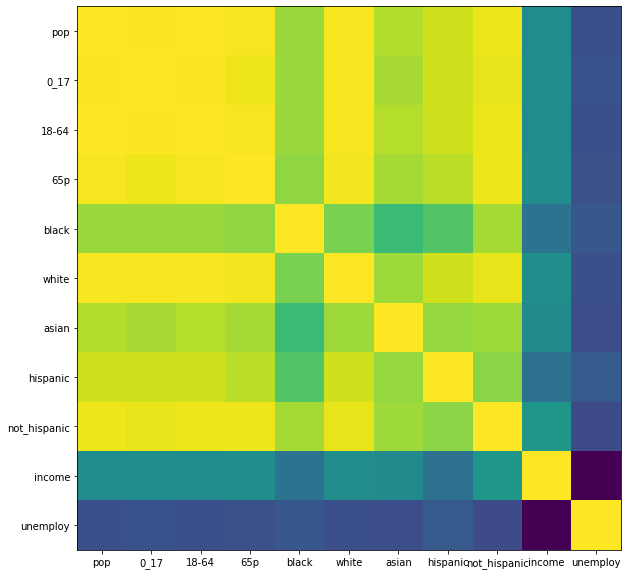

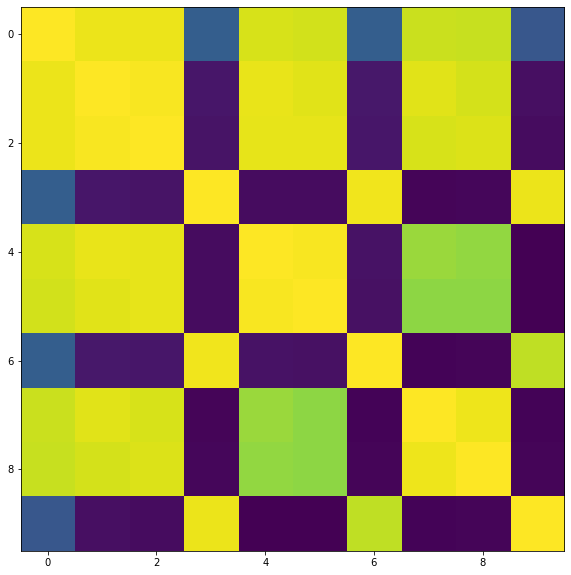

In [19]:
"""
demograph features
"""
demographs_.shape # torch.Size([2334, 14])

plt.figure(figsize=(10, 10))
plt.imshow(np.corrcoef(demographs_.T.cpu().numpy()))
plt.xticks(np.arange(11), ['pop', '0_17', '18-64', '65p', 'black', 'white', 'asian', 'hispanic', \
                           'not_hispanic', 'income', 'unemploy'])
plt.yticks(np.arange(11), ['pop', '0_17', '18-64', '65p', 'black', 'white', 'asian', 'hispanic', \
                           'not_hispanic', 'income', 'unemploy'])
A1_demo, A2 = NTF_2d(demographs_[:, :-2], *initialize(demographs_[:, :-2], R=1, device=device), iteration=20)
pickle.dump([A1_demo, demographs[:, 0].cpu().numpy()], open("demongraphs.pkl", "wb"))


# """
# claims features
# """
# claim_ = daily_[:, :, :20] 
# claim_.shape # torch.Size([2334, 639, 20])

# plt.figure(figsize=(10, 10))
# plt.imshow(np.corrcoef(claim_.permute(2, 0, 1).reshape(20, -1).cpu().numpy()))
# A1, A2, A3 = NTF_3d(claim_, *initialize(claim_, R=3, device=device), iteration=20)


# """
# covid features
# """
# covid_ = daily_[:, :, 20] 
# covid_.shape # torch.Size([2334, 639])

# plt.figure(figsize=(10, 10))
# plt.imshow(np.corrcoef(covid_.T.cpu().numpy()))
# A1, A2 = NTF_2d(covid_, *initialize(covid_, R=1, device=device), iteration=20)


"""
vaccine features
"""
vaccine_ = daily[:, :, 25:][:, :, :10]
vaccine_.shape # torch.Size([2318, 639, 34])

plt.figure(figsize=(10, 10))
plt.imshow(np.corrcoef(vaccine_.permute(2, 0, 1).reshape(10, -1).cpu().numpy()))
A1_vac = []
vac_12 = []
vac_bst = []

interval = 28
for i in range(vaccine_.shape[1]//interval):
    A1, A2, A3 = NTF_3d(vaccine_[:, i*interval:i*interval+interval, :], \
                        *initialize(vaccine_[:, i*interval:i*interval+interval, :], R=2, device=device), iteration=50)
    A1_vac.append(A1)
    vac_12.append(vac_tensor[:, i*interval:i*interval+interval, [1,2]].sum(1).sum(1).cpu().numpy())
    vac_bst.append(vac_tensor[:, i*interval:i*interval+interval, 3].sum(1).cpu().numpy())
pickle.dump([A1_vac, vac_12, vac_bst], open("vaccine.pkl", "wb"))

In [18]:
A1_vac[-1]

array([[1.3735431e+02, 4.2247515e+00],
       [2.8604187e+02, 2.4671188e+01],
       [5.0493694e+01, 3.4677520e-01],
       ...,
       [9.9999999e-09, 2.4644065e+00],
       [6.0316422e+01, 5.0256500e+00],
       [1.6051760e+01, 2.4192111e+00]], dtype=float32)

### FINAL: dump cluster out

In [63]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
pickle.dump(A1.cpu().numpy(), open("decomp.pkl", "wb"))

In [ ]:
#

# some analysis

(array([ 53.,   1.,   8.,  71., 222., 361., 740., 674., 179.,   9.]),
 array([-18.420681 , -16.195503 , -13.970326 , -11.74515  ,  -9.519972 ,
         -7.2947946,  -5.0696173,  -2.84444  ,  -0.6192627,   1.6059146,
          3.831092 ], dtype=float32),
 <BarContainer object of 10 artists>)

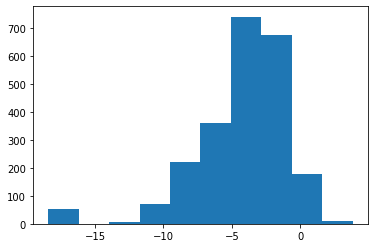

In [481]:
plt.hist(np.log(A1_vacc[:, 1]))

In [482]:
np.log(A1_vacc[:, 1])

array([-2.640508 , -0.840762 , -5.3616257, ..., -3.205732 , -2.4626677,
       -3.2202334], dtype=float32)

In [484]:
demographs[:, 0]

tensor([ 55601., 218022.,  24881.,  ...,  27545.,  50185.,  33860.])